In [1]:
import sys, cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import collections
from dataclasses import dataclass
from tqdm.notebook import tnrange, tqdm

# Reading Dumped data

In [2]:
with open('sortedFish.pik','rb') as f:
    sortedFish=pickle.load(f)

posU=sortedFish[0]
nonOverlappingRange=sortedFish[1]
fishU=sortedFish[2]

fishU=frame,fish,pixel,[row,col,grey]

262 30 113.57956808685125 111.0


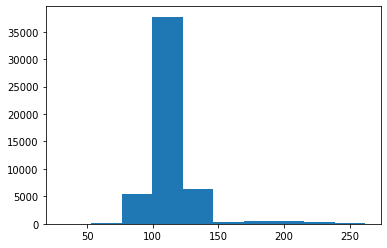

(array([    0,     1,     2, ..., 51211, 51212, 51213], dtype=int64),)


In [3]:
# Pixels should be over 150, here's how many are.
pixelCount=[]
for i in range(len(fishU)):
    pixelCount.append(len(fishU[i][0]))
print(max(pixelCount),min(pixelCount),np.mean(pixelCount),np.median(pixelCount))
plt.hist(pixelCount)
plt.show()
pixelCount=np.array(pixelCount)
print(np.where(pixelCount<150))

# Creating a distance histogram out of the sorted data

### Creating histograms for the first fish over the first nonoverlapping range

### Function to create histograms

In [4]:
def histMaker(histData,bins1,bins2):
    '''
    Creates a 2d histogram.
    
    Input:
        histData:Either histSum or histDif. Some sort of array?
        bins1:The distance bins. np.linspace(int,int,int)
        bins2:The sum/difference bins. np.linspace(int,int,int)
    '''
    #fig=plt.figure(figsize=(5,5))
    
    plt.imshow(histData[:,::-1].T,extent=[bins1[0], bins1[-1], bins2[0], bins2[-1]],aspect='auto')
    plt.colorbar()
    
    #plt.show()

### Creating histograms for two fish over the first n nonoverlapping ranges.

In [5]:
binsDist=np.linspace(0,30,30)
binsDif=np.linspace(0,50,50)
binsSum=np.linspace(150,350,200)
histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

In [ ]:
#binsDist=np.linspace(0,30,30)
#binsDif=np.linspace(0,50,50)
#binsSum=np.linspace(150,350,200)
#histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
#histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

histSumList={}
histDifList={}

#i=num nonOverlappingRanges
#k=num fish
#j=frame in nonOverlappingRange
#l=pixels in frame
#m=

for i in tnrange(30,desc='nonOverlappingRange'):
    for k in tnrange(2,desc='fish'):
        countSum=0
        countDif=0
        pairData=[]
        for j in tnrange(*nonOverlappingRange[i],desc='frame'):
            fishList = fishU[j][k]
            for l in range(fishList.shape[0]):
                for m in range(l):
                    d=np.sqrt((fishList[l,0]-fishList[m,0])**2+(fishList[l,1]-fishList[m,1])**2)
                    bSum=fishList[l,2]+fishList[m,2]
                    bDif=fishList[l,2]-fishList[m,2]
                    pairData.append([d,bSum,bDif])
            pairDataT = np.array(pairData).T
            heightValuesSum,_,_=np.histogram2d(pairDataT[0],pairDataT[1],bins=(binsDist,binsSum))
            histSum+=heightValuesSum
            countSum+=1
            heightValuesDif,_,_=np.histogram2d(pairDataT[0],pairDataT[2],bins=(binsDist,binsDif))
            histDif+=heightValuesDif
            countDif+=1
        histSum/=countSum
        #histSumList['nonOverlappingRange%s-fish%s'%(i,k)]=histSum.copy()
        #nonOverlappingRange,fish
        histSumList[i,k]=histSum.copy()
        histDif/=countDif
        #histDifList['nonOverlappingRange%s-fish%s'%(i,k)]=histDif.copy()
        #nonOverlappingRange,fish
        histDifList[i,k]=histDif.copy()

        
histLists=[histSumList,histDifList]
#histLists={'histSumList':histSumList,'histDifList':histDifList}
with open('histLists.pik','wb') as f:
    pickle.dump(histLists,f)

In [ ]:
with open('histLists.pik','rb') as f:
    histLists=pickle.load(f)

#globals().update(histLists)
histSumList=histLists[0]
histDifList=histLists[1]

In [ ]:
n=len(histSumList.keys())
plt.figure(figsize=(10,(n//2)*4))
for i,k in enumerate(histSumList.keys()):
    plt.subplot(n//2,2,i+1)
    histMaker(histSumList[k],binsDist,binsSum)
    plt.title(f'nonOverlappingRange{k[0]}, fish{k[1]}')
plt.show()

### Checking distances between the histograms

# Use scipy.spatial.distance.cdist instead?

In [ ]:
def swapStatus(histList):
    '''
    Detext swaps between consecutive nonOverlappingRanges based on brightness sum and difference.
    
    Input:
        histList: . Dictionary
    
    Output:
        Int. 0 if no swaps, 1 if swapped, 2 if overlapping.
    '''
    
    #histList=list(histDict.values())
    
    distanceMatrix=[np.linalg.norm(histList[0,0]-histList[1,0]),
        np.linalg.norm(histList[1,0]-histList[1,1]),
        np.linalg.norm(histList[0,1]-histList[1,0]),
        np.linalg.norm(histList[0,1]-histList[1,1])]
    
    swapCriteron=(distanceMatrix[0]+distanceMatrix[1])-(distanceMatrix[2]+distanceMatrix[3])
    if abs(swapCriteron)<1e-10:
        return 2 #Overlapping
    elif swapCriteron>0:
        return 1 #Swapped
    elif swapCriteron<0:
        return 0 #Normal
    else:
        return -1

In [ ]:
swapStatus(histSumList)

In [ ]:
dH=np.mean([np.absolute(histSumList[i,0]-histSumList[0,1]) for i in range(2)],axis=0)
histMaker(dH,binsDist,binsDif)
plt.show()

H=histSumList
distMat=np.array([[H[1,0]-H[0,0],H[1,0]-H[0,1]],
                 [H[1,1]-H[0,0],H[1,1]-H[0,1]]])
#multiply by dH, sum

## Creating a graph on onaxis distances vs off axis distances

In [ ]:
def swapMatrix(histList):
    '''
    Creates a list of pairs consisting of the onAxxiss distance and the off axis distance for a given set of histograms.
    
    Input:
    
    Output: [[,],[,]]
    '''
    nOverlap=list(histList.keys())[-1][0]
    
    distanceMatrix=[]
    for i in range(nOverlap):
        distSame=np.linalg.norm(histList[i+1,0]-histList[i,0])+np.linalg.norm(histList[i+1,1]-histList[i,1])
        distDiff=np.linalg.norm(histList[i+1,1]-histList[i,0])+np.linalg.norm(histList[i+1,0]-histList[i,1])
        distanceMatrix.append([distSame,distDiff])
    
    return(distanceMatrix)

In [ ]:
distanceMatrix=swapMatrix(histSumList)

plt.plot(np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.plot(np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.scatter(np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [ ]:
def swapLister(distanceMatrix):
    '''
    
    '''
    swapList=[]
    
    for i in range(len(distanceMatrix)):
        if distanceMatrix[i][1]>distanceMatrix[i][0]:
            swapList.append(i)
        
    return(swapList)

In [ ]:
print(distanceMatrix)
print(swapLister(swapMatrix(histSumList)))

In [ ]:
distanceMatrix=swapMatrix(histDifList)

plt.plot(np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.plot(np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.asarray(distanceMatrix).T[0],label='Sum of Diagonal Distances')
plt.scatter(np.asarray(distanceMatrix).T[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [ ]:
print(distanceMatrix)
print(swapLister(swapMatrix(histDifList)))